In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords
from pymongo import MongoClient
from time import time
from collections import Counter
import pandas as pd
import numpy as np
import os


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# default plot stying changes
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1., rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette('Set2',12)

# Credentials

In [4]:
pw_file = 'pw.txt'
if os.path.exists(pw_file): 
    with open(pw_file, 'r') as f:
        email, indeed_pw = f.readline().strip().split(', ')
        username, pia_pw = f.readline().strip().split(', ')
        pub_ip, mongo_usr, mongo_usr_pw = f.readline().strip().split(', ')

# Connect to DB

In [5]:
# connect to ec2 mongo client
client = MongoClient('{0}:27017'.format(pub_ip))


In [6]:
# get reference to  resume_db
db = client.resume_db

In [7]:
# authenticate user for database
db.authenticate(mongo_usr, mongo_usr_pw)

True

# Pull MongoDB into Dataframe

In [8]:
def read_mongo(db, collection, query={}, no_id=True):
    '''
    db: mongodb already connected and authenticated
    collection: desired collection in db
    query: query filter
    no_id: include mongos _id (False) or not (True)
    return => pandas dataframe
    '''
    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [9]:
t_start = time()

# load database data into dataframe
df = read_mongo(db, 'originals')

print('Time to load data: {0}s'.format(time() - t_start))

Time to load data: 9.051632165908813s


In [10]:
df.head()

,link_id,resume_text,search_term
0,/r/2b5b06cff39ce808?,"Petros Gazazyan North Hollywood, CA Werkervari...",engineer
1,/r/8fe4de80947b60f2?,"Travis London Java Software Engineer Tucson, A...",engineer
2,/r/1c009e8f7e2f5309?,"Stephen A. Kraft Mechanical Engineer Seattle, ...",engineer
3,/r/f18875e484d5b766?,"Abdy Galeano Duarte, CA Utilize my skills and ...",engineer
4,/r/818d4e5de7455e18?,Thithi McWilliams New Product Development Engi...,engineer


In [11]:
print(list(df['search_term'].unique()))

['engineer', 'analytics', 'data_analysis', 'data', 'big_data', 'scientist']


# Remove StopWords

In [37]:
# cache stopwords first to reduce compute time
cachedStopWords = stopwords.words("english")
cachedStopWords.append(',')

# convert all text to lower case and separate into list
df['resume_stopped'] = df['resume_text'].str.lower().str.split()

# remove stopwords
df['resume_stopped'] = df['resume_stopped'].apply(lambda x: ' '.join([item for item in x if item not in cachedStopWords]))

In [38]:
df.head()

,link_id,resume_text,search_term,resume_stopped
0,/r/2b5b06cff39ce808?,"Petros Gazazyan North Hollywood, CA Werkervari...",engineer,"petros gazazyan north hollywood, ca werkervari..."
1,/r/8fe4de80947b60f2?,"Travis London Java Software Engineer Tucson, A...",engineer,"travis london java software engineer tucson, a..."
2,/r/1c009e8f7e2f5309?,"Stephen A. Kraft Mechanical Engineer Seattle, ...",engineer,"stephen a. kraft mechanical engineer seattle, ..."
3,/r/f18875e484d5b766?,"Abdy Galeano Duarte, CA Utilize my skills and ...",engineer,"abdy galeano duarte, ca utilize skills experie..."
4,/r/818d4e5de7455e18?,Thithi McWilliams New Product Development Engi...,engineer,thithi mcwilliams new product development engi...


# Word Frequency

In [63]:
# get wordcounts
wordcount = Counter(' '.join(df['resume_stopped']).split(' '))

# limit wordcounts for visualization
#wordcount = wordcount.most_common(30)

In [73]:
pd.DataFrame(wordcount.items())

PandasError: DataFrame constructor not properly called!

In [50]:
labels = [lbl for lbl, ct in wordcount]
count = [ct for lbl, ct in wordcount]

TypeError: unsupported operand type(s) for -: 'str' and 'float'

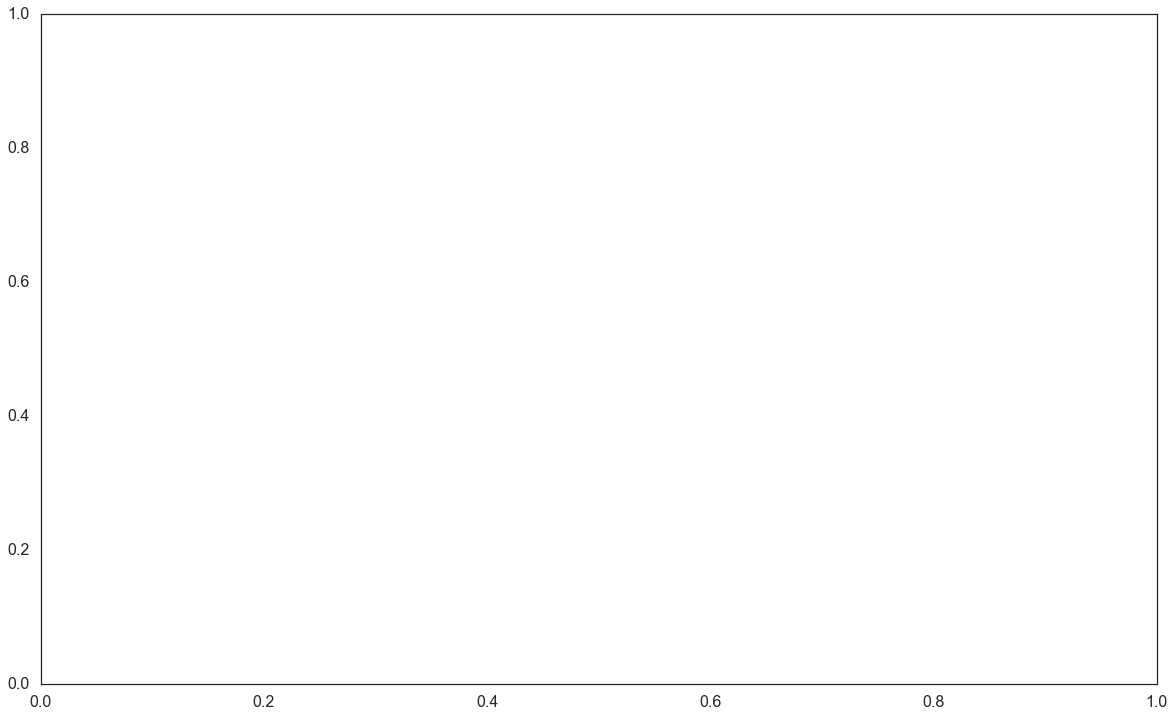

In [52]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# plots
ax.bar(labels,count, align='center')

#plt.xlim(-0.05,1.05)
#plt.ylim(-0.05,1.05)

# labels/titles
plt.legend(loc="best")
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.xaxis.grid(True, alpha=0.2) 
ax.yaxis.grid(True, alpha=0.2) 

# plot that biddy
plt.tight_layout()
_ = plt.show()

# Count Vectorizer

In [ ]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

In [ ]:
t_start = time()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(df['resume_text'])

print('Time to count vectorize data: {0:.4}s'.format(time() - t_start))

In [ ]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0)

t_start = time()

lda.fit(tf)

print('Time to count vectorize data: {0:.4}s'.format(time() - t_start))

In [ ]:
print("Topics in LDA model:")

# get feature names (topics) from model
tf_feature_names = tf_vectorizer.get_feature_names()

print('Start of list: ' + ', '.join(tf_feature_names[:12]))
print('End of list: ' + ', '.join(tf_feature_names[-12:]))

In [ ]:
def print_top_words(model, feature_names, top_words):
    for i, topic in enumerate(model.components_):
        print("Topic {0}:".format(i))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

In [ ]:
print_top_words(lda, tf_feature_names, 10)